In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

In [3]:
X = train.drop('label', axis= 1)
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
mps_device = torch.device("mps")

X_train = torch.FloatTensor(X_train).to(mps_device)
y_train = torch.LongTensor(np.array(y_train)).to(mps_device)
X_val = torch.FloatTensor(X_val).to(mps_device)
y_val = torch.LongTensor(np.array(y_val)).to(mps_device)
X_test = torch.FloatTensor(X_test).to(mps_device)

In [7]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [8]:
input_size = X_train.shape[1]
hidden_size = 2000
output_size = 10
model = ANN(input_size, hidden_size, output_size).to(mps_device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 400
final_losses=[]
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    final_losses.append(loss.item())
    loss.backward()
    optimizer.step()

In [11]:
### plot the loss function
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Training Loss Over Epochs')

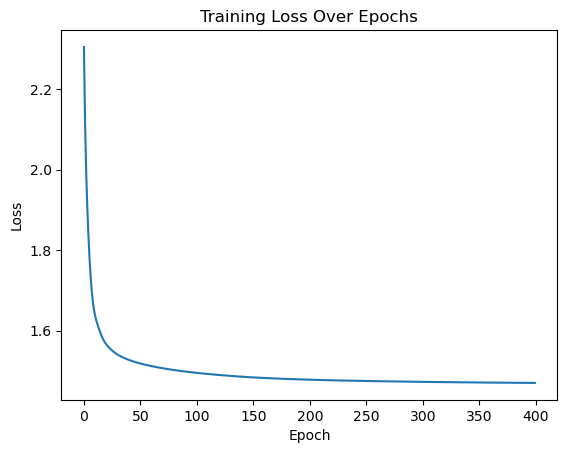

In [12]:
plt.plot(final_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

In [13]:
model.eval()
with torch.no_grad():
    val_predictions = model(X_val)
    _, predicted_labels_val = torch.max(val_predictions, 1)

In [14]:
accuracy_val = (predicted_labels_val == y_val).float().mean().item()
accuracy_val

0.9654761552810669

In [16]:
with torch.no_grad():
    test_predictions = model(X_test)
    _, predicted_labels_test = torch.max(test_predictions, 1)

In [17]:
predicted_labels_np = predicted_labels_test.numpy()

submission = pd.DataFrame()
submission['ImageId'] = range(1, len(predicted_labels_np)+1)
submission['Label'] = predicted_labels_np

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [18]:
submission.to_csv("ANN.csv", index=False)

NameError: name 'submission' is not defined

In [ ]:
from torchviz import make_dot
sample_input = torch.randn((1, input_size))

output = model(sample_input)
graph = make_dot(output, params=dict(model.named_parameters()))

graph.render(filename='simple_nn_graph', format='png', cleanup=True)

graph.view()
